# A Disentangled VAE-BiLSTM Model for Heart Rate Anomaly Detection 코드 리뷰
`2025712777 진태헌`    
캡스톤 6팀

## 버전 확인

Tensorflow 설치

- pip install tensorflow==2.10
> tensorflow 2.10 버전으로 설치

### 필요한 라이브러리

`요구 사항`
- keras==2.10.0
- matplotlib==3.7.1
- numpy==1.21.6
- pandas==1.5.3
- PyYAML==6.0
- scikit-learn==1.2.2
- scipy==1.10.1
- seaborn==0.12.2
- tensorflow==2.10.0

---
# 사전 준비

## git clone

해당 프로젝트는 관련 파일들이 많아 실제 깃허브 레포지토리에 있는 파일을 git clone 을 통해 가져옴    

In [ ]:
!git clone https://github.com/staale92/disentangled-vae-bilstm.git

## 시계열 심박수 데이터 생성 함수

### `def time_series_generator(median, outlier_err, size, outlier_size)`

시계열 데이터를 생성하는 함수 

매개변수:
- median: 중심값 (중앙값)으로 사용될 기준값
- outlier_err: 이상치(outlier)의 최대 편차 범위
- size: 정상(normal) 데이터의 개수
- outlier_size: 이상치 데이터의 개수 (총 개수: 하단 + 상단)

반환값:
- numpy 배열 형태의 시계열 데이터 (정상값 + 이상치 포함, 섞여 있음)

In [1]:
import numpy as np
import pandas as pd


# 시계열 데이터를 생성하는 함수 정의
def time_series_generator(median, outlier_err, size, outlier_size):
    
    # 정상 데이터 생성: -1 또는 1 중 무작위 방향으로 작은 오차를 더해줌
    
    # -1 또는 1을 곱한 무작위 오차
    errs = np.random.rand(size) * np.random.choice((-1, 1), size)
    data = median + errs # 중심값에 위에서 만든 작은 오차를 더해 정상 데이터 생성

    
    # 하단 이상치 생성: 중심값보다 작은 값으로 생성
    
    # 하단으로 벗어나는 오차
    lower_errs = outlier_err * np.random.rand(int(outlier_size/2))
    lower_outliers = median - lower_errs # 중심값보다 작게 만들어 하단 이상치 생성

    
    # 상단 이상치 생성: 중심값보다 큰 값으로 생성
    
    # 상단으로 벗어나는 오차
    upper_errs = outlier_err * np.random.rand(int(outlier_size/2))
    upper_outliers = median + upper_errs # 중심값보다 크게 만들어 상단 이상치 생성

    
    # 정상 데이터 + 이상치 데이터를 합치고 무작위로 섞음
    data = np.concatenate((data, lower_outliers, upper_outliers))
    np.random.shuffle(data)  # 데이터를 섞어서 이상치가 눈에 띄지 않도록 함
    return data

## 데이터셋 시각화

time_series_generator 함수로 생성되는 시계열 데이터를 그래프로 시각화    
일부 데이터는 이상치(outliers)를 포함    

주요 단계:

1. 시드 고정: np.random.seed(42)로 난수 생성 일관성 유지
1. 데이터 생성: time_series_generator()를 이용해 중심값 70, 이상치 범위 ±20 내에서 1. 100개의 정상값과 10개의 이상치를 생성
1. 시각화: matplotlib를 이용해 선 그래프로 출력
1. 데이터 저장: Pandas DataFrame으로 변환 (CSV 저장은 주석 처리됨)

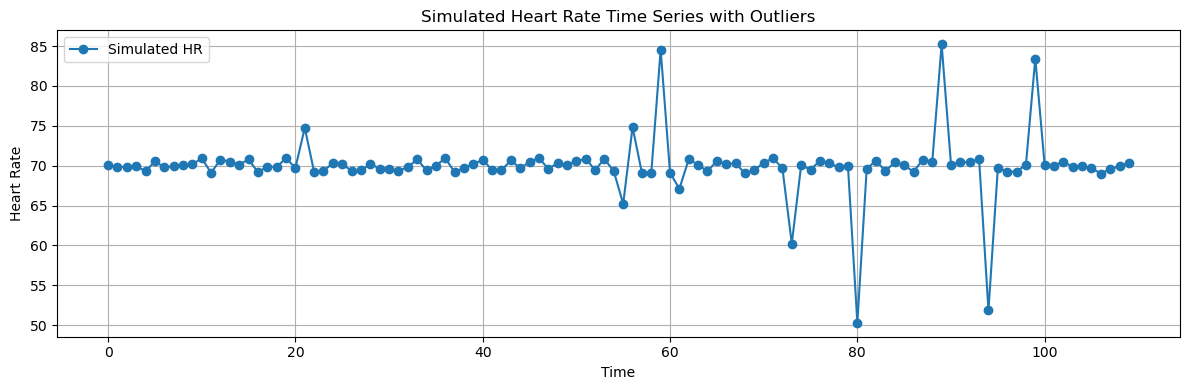

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 난수 시드 설정 (재현 가능한 결과를 위해)
np.random.seed(42)

# 시뮬레이션된 심박수 데이터 생성
simulated_hr = time_series_generator(
    median=70, outlier_err=20, size=100, outlier_size=10
)

# 시계열 그래프 시각화
plt.figure(figsize=(12, 4))
plt.plot(simulated_hr, marker='o', linestyle='-', label='Simulated HR')
plt.title("Simulated Heart Rate Time Series with Outliers")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 데이터프레임으로 변환
df = pd.DataFrame({"HeartRate": simulated_hr})

# CSV 저장 (필요 시 주석 해제)
# df.to_csv("simulated_hr_data.csv", index=False)


그림은 생성된 심박수 시계열 데이터 시각화 예시

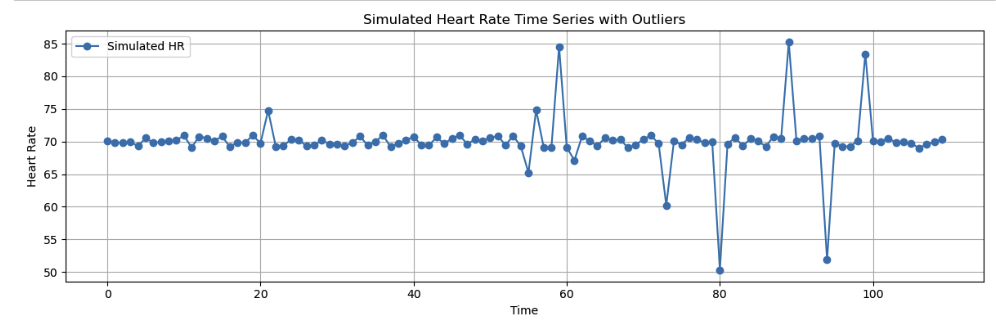

# 모델 구축

## 데이터 라벨링

여러 가지 이상치 탐지 알고리즘(Isolation Forest, KDE, One-Class SVM, Sliding Window)을 활용해 시계열 데이터의 이상치를 탐지하고 이 결과를 통합하여 DataFrame에 라벨링

입력값:
- `data_df`: 이상치 탐지를 적용할 데이터프레임 (HR 컬럼 포함)
- `data`: 원본 데이터 배열 (data_df와 동일 구조)
- `if_*`: Isolation Forest 관련 파라미터
- `kd_*`: Kernel Density Estimation 관련 파라미터
- `svm_*`: One-Class SVM 관련 파라미터
- `sw_*`: Sliding Window 관련 파라미터

반환값:

- `data_df`: 이상치 라벨 컬럼이 추가된 데이터프레임
- `total_anomalies`: 최종 이상치 인덱스 모음
- `time`: 시계열 인덱스 (0 ~ N)    

이상치 기준:

- Isolation Forest, KDE, SVM 모두 이상치로 판단한 데이터 (intersection)
- Sliding Window에서 이상치로 판단한 데이터 (union)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM

def data_labeling_algorithm(data_df, data,
                            if_estimators, if_random_state, if_contamination, 
                            kd_algo, kd_kernel, kd_metric, kd_score,
                            svm_nu, svm_kernel, svm_gamma,
                            sw_window_percentage, sw_std):
    
    # Isolation Forest 적용
    model_if = IsolationForest(n_estimators=if_estimators, random_state=if_random_state, contamination=if_contamination)
    model_if.fit(data_df.values)
    anomaly_dict = {-1: True, 1: False}
    data_df["anomaly_if"] = model_if.predict(data_df.values)
    data_df["anomaly_if"] = data_df["anomaly_if"].map(anomaly_dict)
    anomalies_if = data_df[data_df.anomaly_if == True]

    # Kernel Density Estimation 적용
    kern_dens = KernelDensity(algorithm=kd_algo, kernel=kd_kernel, metric=kd_metric)
    kern_dens.fit(data_df.values)
    scores = kern_dens.score_samples(data_df.values)
    threshold = np.quantile(scores, kd_score)
    data_df["anomaly_kde"] = np.where(scores <= threshold, -1, 1)
    data_df["anomaly_kde"] = data_df["anomaly_kde"].map(anomaly_dict)
    anomalies_kde = data_df[data_df.anomaly_kde == True]

    # Fit One Class SVM 적용
    one_class_svm = OneClassSVM(nu=svm_nu, kernel=svm_kernel, gamma=svm_gamma).fit(data_df.values)
    data_df["anomaly_svm"] = one_class_svm.predict(data_df.values)
    data_df["anomaly_svm"] = data_df["anomaly_svm"].map(anomaly_dict)
    anomalies_svm = data_df[data_df.anomaly_svm == True]

    # Sliding Window 적용
    column = data_df[["HR"]].to_numpy().reshape(-1,)
    N = len(column)
    time = np.arange(0,N)
    window_percentage = sw_window_percentage
    k = int(len(column) * (window_percentage/100))
    for_bands = pd.DataFrame(data).reset_index()
    
    # 윈도우 기준 상하한 계산 함수
    get_bands = lambda for_bands : (np.mean(for_bands) + sw_std*np.std(for_bands),
                                    np.mean(for_bands) - sw_std*np.std(for_bands))
    bands = [get_bands(column[range(0 if i-k < 0 else i-k, i+k if i+k < N else N)]) for i in range(0,N)]
    upper, lower = zip(*bands)
    
    # 상하한 벗어난 값은 이상치로 라벨링
    data_df["anomaly_sw"] = (column > upper) | (column < lower)
    anomalies_sw = data_df[data_df.anomaly_sw == True]

    # 각 알고리즘의 이상치 인덱스 집합
    index_anomalies_if = set(anomalies_if.index)
    index_anomalies_kde = set(anomalies_kde.index)
    index_anomalies_svm = set(anomalies_svm.index)
    index_anomalies_sw = set(anomalies_sw.index)

    # 세 알고리즘(IF, KDE, SVM)이 공통으로 이상치로 판단한 것
    anomalies_1st_group = set.intersection(index_anomalies_if, index_anomalies_kde, index_anomalies_svm)
    
    # Sliding Window 결과 포함한 전체 이상치
    total_anomalies = anomalies_1st_group.union(index_anomalies_sw)
    data_df["total_anomalies"] = data_df.index.isin(total_anomalies)
    
    return data_df, total_anomalies, time

### 라벨링 시각화

1. 데이터 생성
- time_series_generator 함수를 이용해서 심박수 데이터를 인위적으로 만듦

2. 이상치 탐지
- 생성된 데이터를 가지고 다양한 이상치 탐지 알고리즘을 적용
- `Isolation Forest`: 데이터 간의 분리 정도를 보고 이상치 판별
- `Kernel Density Estimation`: 밀도가 낮은 영역을 이상치로 간주
- `One-Class SVM`: 정상 데이터의 패턴에서 벗어난 점들을 이상치로 감지
- `Sliding Window 방식`: 특정 범위 안에서 평균과 표준편차를 계산하고, 그 범위를 벗어나는 값을 이상치로 간주
- 이 네 가지 방법의 결과를 종합해서 이상치로 의심되는 데이터들을 하나로 통합

3. 시각화

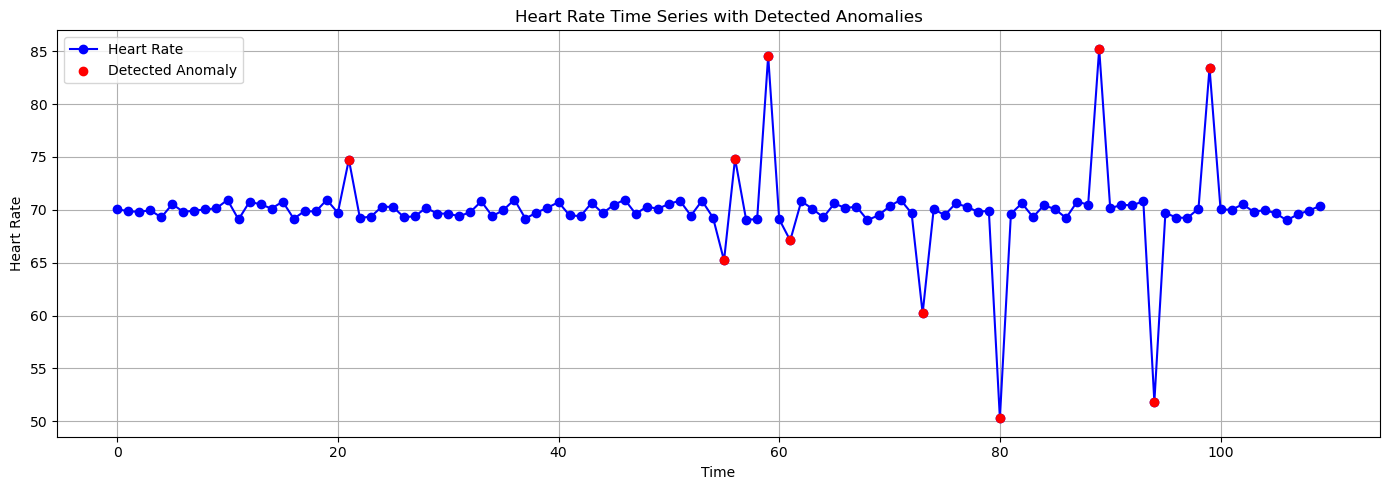

In [4]:
# 1. 데이터 생성

np.random.seed(42)
data = time_series_generator(median=70, outlier_err=20, size=100, outlier_size=10)
data_df = pd.DataFrame({"HR": data})

# 2. 이상치 탐지

data_df, total_anomalies, time = data_labeling_algorithm(
    data_df=data_df,
    data=data,
    if_estimators=100, if_random_state=42, if_contamination=0.1,
    kd_algo="auto", kd_kernel="gaussian", kd_metric="euclidean", kd_score=0.1,
    svm_nu=0.1, svm_kernel="rbf", svm_gamma='scale',
    sw_window_percentage=10, sw_std=2
)

# 3. 시각화

plt.figure(figsize=(14, 5))
plt.plot(time, data_df["HR"], label='Heart Rate', color='blue', marker='o', linestyle='-')

# 이상치 점만 따로 표시
anomaly_indices = data_df[data_df["total_anomalies"] == True].index
plt.scatter(anomaly_indices, data_df.loc[anomaly_indices, "HR"],
            color='red', label='Detected Anomaly', zorder=10)

plt.title("Heart Rate Time Series with Detected Anomalies")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

데이터 라벨링 시각화 예시

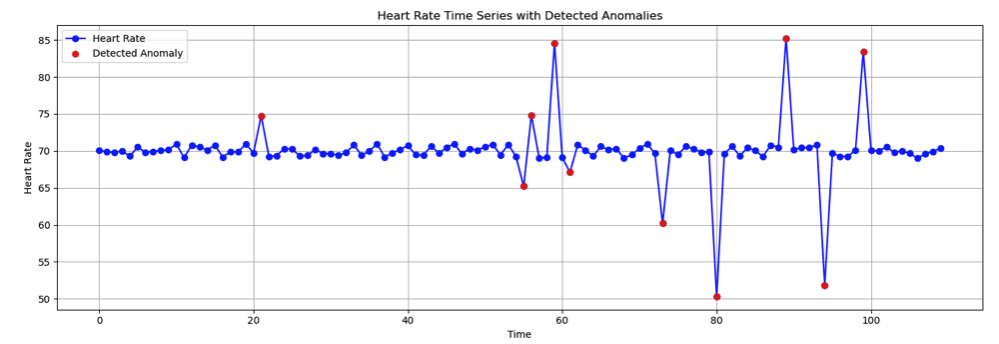

## β-VAE-BiLSTM 이상 탐지 시스템 파이프라인 구성 함수

이 코드는 β-VAE-LSTM 기반 이상치 탐지 시스템의 주요 파이프라인을 구성

1. 데이터 분할 및 전처리
    - 시계열 데이터를 학습/검증/테스트로 분할
    - 이상치가 포함된 학습 데이터는 이상치 값을 제거하고 보간하여 정제
 
<br>


2. 데이터 변환 및 모델 입력 준비
    - 정규화 (scaling)
    - LSTM 입력을 위한 시계열 분할 (windowing)
    - VAE를 통해 embedding 및 reconstruction 수행    
    
<br>  

3. 이상치 탐지 및 평가
    - reconstruction error 계산 후 threshold로 이상치 감지
    - ground truth와 비교하여 precision, recall, F1-score 계산
    - 다양한 threshold margin을 실험하여 최적값 선택

`data_split`: 데이터를 학습/검증/테스트로 분할    
- 주어진 인덱스를 기준으로 데이터를 3개로 분할함
- HR(심박수) 컬럼만 선택해서 반환

`train_cleaning`: 학습 데이터에서 이상치 제거
- 이상치가 있는 지점을 NaN으로 만들고 앞뒤 값으로 채움

`anomalies_validation_test`: 검증/테스트셋에서의 이상치 인덱스 확인
- 전체 시계열에서 이상치가 validation/test에 있는지 확인하는 함수

In [5]:
import numpy as np
import pandas as pd

def data_split(data_df, train_delimiter, validation_delimiter):
    train, validation, test = data_df[:train_delimiter]['HR'], data_df[train_delimiter:validation_delimiter]['HR'], data_df[validation_delimiter:]['HR']
    print("Train size: ", train.shape)
    print("Validation size: ",validation.shape)
    print("Test size: ", test.shape)
    return train, validation, test

def train_cleaning(train, anomalies):
    train_df = pd.DataFrame(train.values)
    # Make all anomalies NaN values, then fill them with previous non-anomalous value 
    # This is to construct train data with only normal HR behaviour
    train_df[train_df.index.isin(anomalies)] = np.nan
    cleaned_train = train_df.fillna(method="ffill").fillna(method="bfill")
    return cleaned_train

def anomalies_validation_test(cleaned_train, validation, test, time, anomalies):
    index_validation = list(range(len(cleaned_train), len(cleaned_train) + len(validation)))
    index_test = list(range(len(cleaned_train + validation), len(cleaned_train + validation) + len(test)))
    # Existing anomalies in validation and test
    index_anomalies_validation = list(validation.reindex(time[anomalies]).dropna().index)
    index_anomalies_test = list(test.reindex(time[anomalies]).dropna().index)
    return index_anomalies_validation, index_anomalies_test

`find_threshold`: 에러 기반 threshold 계산
- reconstruction error 평균 + margin × 표준편차로 threshold 설정

`find_anomalies`: threshold를 기반으로 이상치 판단    
`predict_index`: LSTM 예측 인덱스 계산    
`data_scaling`: MinMaxScaler 등으로 데이터 정규화

In [6]:
def find_threshold(squared_errors, margin):
    threshold = np.mean(squared_errors) + margin * np.std(squared_errors)
    return threshold

def find_anomalies(squared_errors, threshold):
    anomalies = (squared_errors >= threshold)
    return anomalies

def predict_index(df, X_train, n_steps_in, n_steps_out):
    train_predict_index = df.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out -1, :].index
    test_predict_index = df.iloc[X_train.shape[0] + n_steps_in:, :].index
    return train_predict_index, test_predict_index

def data_scaling(train_df,validation_df,test_df, scaler):
    scaler = scaler.fit(train_df[["HR"]])

    train_df["HR"] = scaler.transform(train_df[["HR"]])
    validation_df["HR"] = scaler.transform(validation_df[["HR"]])
    test_df["HR"] = scaler.transform(test_df[["HR"]])
    return train_df, validation_df, test_df

`split_sequence`: LSTM 학습을 위한 입력/출력 쌍 생성    
`reconstruction_loss`: VAE 모델의 reconstruction loss 계산    
`mean_across_steps`: 예측값과 실제값의 시계열 평균 계산

In [7]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    """split a univariate sequence into samples"""
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def reconstruction_loss(vae, train_X):
    # Reconstruction loss on training set
    x_train_pred = vae.predict(train_X)
    train_mae_loss = np.mean(np.abs(x_train_pred - train_X), axis=1)
    return train_mae_loss

def mean_across_steps(saved_model, embeddings_X, embeddings_y, index, n_steps_out):
    # Model predictions
    vae_lstm_pred = saved_model.predict(embeddings_X,verbose=0)
    # Flatten the predictions by taking the mean across steps
    predict_result = pd.DataFrame()
    for i in range(vae_lstm_pred.shape[0]):
        y_predict = pd.DataFrame(vae_lstm_pred[i], columns=["predicted"], index = index[i: i + n_steps_out])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    
    real_value = pd.DataFrame()
    for i in range(embeddings_y.shape[0]):
        y_value = pd.DataFrame(embeddings_y[i], columns=["real_value"], index = index[i: i + n_steps_out])
        real_value = pd.concat([real_value, y_value], axis=1, sort=False)
    
    predict_result["predicted_mean"] = predict_result.mean(axis=1)
    real_value["real_mean"] = real_value.mean(axis=1)
    return predict_result, real_value

`model_predictions`: 예측된 임베딩과 실제 임베딩을 재구성    
`decoder_predicted_embeddings`: 임베딩 복원 및 스케일링 복구    
`augmented_detection`: 검출된 이상치 주위까지 확장 탐지    
`intersection`, `list_diff`: 리스트 비교용 유틸 함수

In [8]:
def model_predictions(predict_result, real_value, emb_data_y, latent_space_dim, n_embeddings_in):
    predicted_embeddings = np.array(predict_result["predicted_mean"]).reshape(int(predict_result.shape[0]/ latent_space_dim), latent_space_dim)
    predicted_embeddings = np.concatenate([emb_data_y[-n_embeddings_in:], predicted_embeddings])
    true_embeddings = np.array(real_value["real_mean"]).reshape(int(predict_result.shape[0]/ latent_space_dim), latent_space_dim)
    return predicted_embeddings, true_embeddings

def decoder_predicted_embeddings(decoder, predicted_embeddings, scaler, data_X):
    decoded_yhat = decoder.predict(predicted_embeddings).squeeze()
    rescaled_decoded_yhat = scaler.inverse_transform(decoded_yhat)
    rescaled_data_X = scaler.inverse_transform(data_X.squeeze())
    # Flatten for visualization
    flattened_rescaled_decoded_yhat = np.concatenate(rescaled_decoded_yhat).ravel()
    flattened_rescaled_data_X = np.concatenate(rescaled_data_X).ravel()
    return flattened_rescaled_decoded_yhat, flattened_rescaled_data_X

def augmented_detection(anomalies_vae_lstm, index_anomalies):
    """Augmented anomaly detection (see Xu et al., 2018)"""
    n_anomaly = len(index_anomalies)
    augmented_anomalies_detection = list(anomalies_vae_lstm.index)
    for i in range(n_anomaly):
        for j in anomalies_vae_lstm.index:
            if j in [index_anomalies[i]]:
                original_detection = set(augmented_anomalies_detection)
                for_anomaly_window = set([index_anomalies[i]])
                to_add = list(for_anomaly_window - original_detection)
                augmented_anomalies_detection = augmented_anomalies_detection + to_add
                break
    return list(np.sort(augmented_anomalies_detection))

def intersection(list1, list2):
    list3 = [value for value in list1 if value in list2]
    return list3

def list_diff(list1, list2):
    a = set(list1)
    b = set(list2)
    list3 = [value for value in a if value not in b]
    return list3

`metrics`: Precision, Recall, F1-score 계산    
`margin_comparison_and_selection`: 다양한 threshold margin 실험 후 최적값 선택    

In [9]:
def metrics(index_anomalies, model_anomalies):
    tp = len(intersection(index_anomalies, model_anomalies))
    fp = len(list_diff(model_anomalies, index_anomalies))
    fn = len(list_diff(index_anomalies, model_anomalies))
        
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    return precision, recall, f1_score

def margin_comparison_and_selection(vae_lstm_train_squared_errors, vae_lstm_validation_squared_errors,
                                    validation_df, index_anomalies_validation, flattened_rescaled_validation_X):
    f1_scores = []
    for i in np.arange(start=1, stop=9, step=1):
        threshold = find_threshold(vae_lstm_train_squared_errors, margin=i)
        validation_anomalies = find_anomalies(vae_lstm_validation_squared_errors, threshold)
        
        vae_lstm_validation_df = pd.DataFrame(index=validation_df.index)
        vae_lstm_validation_df["HR"] = flattened_rescaled_validation_X
        vae_lstm_validation_df["anomalies_vae_lstm"] = validation_anomalies
        anomalies_vae_lstm = vae_lstm_validation_df[vae_lstm_validation_df.anomalies_vae_lstm == True]

        augmented_anomalies_vae_lstm = augmented_detection(anomalies_vae_lstm, index_anomalies_validation)

        precision, recall, f1_score = metrics(index_anomalies_validation, augmented_anomalies_vae_lstm)

        print("Margin: ",i)
        print("Precision: ", round(precision,3))
        print("Recall: ", round(recall,3))
        print("F1-Score: ", round(f1_score,3))

        f1_scores.append(f1_score)

    d = dict()
    for i,j in zip(range(1,len(f1_scores)+1),f1_scores):
        d[i]=j
    # Choose the margin with the associated highest F1-score
    selected_margin = max(d, key=d.get)
    print('Selected threshold: ', selected_margin)
    return selected_margin

이렇게 전처리 → 분할 → 임베딩 → 복원 → 이상치 탐지 → 평가까지    
모델 학습과 평가 전 과정을 자동화하기 위한 유틸리티 함수들로 구성

## β-VAE-BiLSTM 모델 구성

##### 이 코드는 시계열 데이터를 처리하기 위한 VAE (Variational Autoencoder) 와 BiLSTM 모델 구조를 정의
- VAE는 시계열 데이터에서 압축된 잠재 표현(latent representation)을 학습
- BiLSTM은 이 임베딩(latent vector)을 기반으로 예측(예: 재구성, 미래값 예측 등)을 수행

### 라이브러리 설명<br/>

- `callbacks` : 조기 종료, 체크포인트 저장
<br/>
- `layers` : 모델 구성 레이어 (LSTM, Dense 등)
<br/>
- `models` : 모델 구조 정의 (Functional, Sequential)
<br/>
- `constraints` : 가중치 제한 (정규화)
<br/>
- `backend` : 커스텀 연산 (Loss 계산 등)
<br/>
- `losses`, `metrics` : 학습 손실 및 평가 지표
<br/>
- `optimizers` : 모델 학습 방식 제어 (Adam 등)
<br/>



In [10]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Lambda, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, MeanAbsoluteError
from tensorflow.keras.metrics import mean_squared_error, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2025-04-16 08:23:43.167895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 08:23:45.557609: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 08:23:46.849299: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 08:23:51.040110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

`vae_sampling`: VAE 샘플링 레이어
- 잠재 공간(latent space)에서 무작위 샘플링을 수행

In [11]:
def vae_sampling(args):
    z_mean, z_log_sigma = args  # 평균과 로그 분산
    batch_size = K.shape(z_mean)[0]
    latent_dim = K.shape(z_mean)[1]
    # 표준 정규분포에서 무작위 샘플링
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
    
    # 재파라미터화 트릭: z = μ + σ * ε
    return z_mean + z_log_sigma * epsilon

`vae_encoder`: VAE 인코더 정의
- 입력 시계열을 잠재 공간으로 인코딩

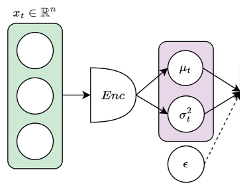
<center> VAE 인코더 </center>

In [12]:
def vae_encoder(input_dim, n_features, latent_space_dim, n_units):
    input_x = Input(shape=(input_dim, n_features,))  # 시계열 입력
    
    # Bidirectional LSTM을 사용하여 입력 시계열 요약
    encoder_LSTM = Bidirectional(LSTM(n_units, kernel_initializer="random_uniform",
                                                   input_shape=(input_dim, n_features,)), 
                                                   merge_mode="ave")(input_x)
    
    # 잠재공간의 평균과 로그분산 추출
    z_mean = Dense(latent_space_dim)(encoder_LSTM)
    z_log_sigma = Dense(latent_space_dim)(encoder_LSTM)

    # 샘플링을 통한 잠재 벡터 생성
    z = Lambda(vae_sampling, output_shape=(latent_space_dim,))([z_mean, z_log_sigma])

    # 모델 정의
    encoder = Model(input_x, [z_mean, z_log_sigma, z], name="encoder")
    encoder.summary()
    return encoder


`vae_decoder`: VAE 디코더 정의
- 잠재 벡터를 원래 시계열로 복원

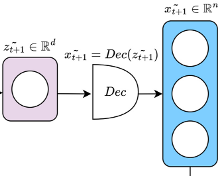
<center> VAE 디코더 </center>

In [13]:
def vae_decoder(input_dim, n_features, latent_space_dim, n_units):
    decoder_input = Input(shape=(latent_space_dim)) # 잠재 벡터 입력

    # 시계열 길이에 맞게 반복
    repeat_decoded = RepeatVector(input_dim)(decoder_input)

    # Bidirectional LSTM으로 시계열 복원
    decoder_LSTM = Bidirectional(LSTM(n_units, kernel_initializer="random_uniform",
                                            input_shape=(input_dim, latent_space_dim,), return_sequences=True),
                                            merge_mode = "ave")(repeat_decoded)
    
    # 시계열 각 시점별 출력 생성
    decoder_output = TimeDistributed(Dense((n_features)))(decoder_LSTM)
    decoder = Model(decoder_input, decoder_output, name="decoder")
    decoder.summary()
    return decoder

`beta_vae`: 전체 VAE 구성 및 loss 정의
- 인코더와 디코더를 연결하고 VAE loss를 정의하는 함수

> beta는 KL divergence의 가중치를 조절해 정보 압축 정도를 조절할 수 있습니다. (β-VAE)

In [14]:
def beta_vae(input_dim, n_features, encoder, decoder, beta):

    input_x = Input(shape=(input_dim, n_features,))

    # 인코더로부터 잠재 변수 생성
    z_mean = encoder(input_x)[0]
    z_log_sigma = encoder(input_x)[1]
    z = encoder(input_x)[2]
    
    # 디코더를 통해 재구성
    output = decoder(z)

    # 전체 모델 구성
    vae = Model(input_x, output, name = 'beta_vae')
    vae.summary()

    # VAE Loss
    reconstruction_loss = mse(input_x, output)
    kl_loss = -0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))

    # 총 loss = 복원 손실 + β * KL 손실 
    total_loss =  reconstruction_loss + beta * kl_loss
    vae.add_loss(total_loss)
    return vae

`bilstm`: BiLSTM 모델 정의
- 임베딩된 시계열 데이터를 기반으로 미래 값을 예측하는 모델

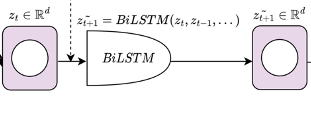
<center> BiLSTM </center>

In [15]:
def bilstm(emb_train_X, n_units, maximum_norm, dropout_rate, n_steps_out) -> tf.keras.models.Model:
    # BiLSTM backend  
    model = Sequential()

    # 첫 번째 BiLSTM 레이어
    model.add(Bidirectional(LSTM(n_units, activation='tanh', return_sequences=True, 
                                kernel_constraint= max_norm(maximum_norm), recurrent_constraint=max_norm(maximum_norm), 
                                bias_constraint=max_norm(maximum_norm),
                                input_shape=(emb_train_X.shape[1],emb_train_X.shape[2]))))
    model.add(Dropout(dropout_rate))

    # 두 번째 BiLSTM 레이어 (절반 크기)
    model.add(Bidirectional(LSTM(int(n_units/2), activation='tanh', return_sequences=True, 
                                kernel_constraint=max_norm(maximum_norm), recurrent_constraint=max_norm(maximum_norm), 
                                bias_constraint=max_norm(maximum_norm))))
    model.add(Dropout(dropout_rate))

    # 세 번째 BiLSTM 레이어 (더 작게)
    model.add(Bidirectional(LSTM(int(n_units/4), activation='tanh', return_sequences=False, 
                                kernel_constraint=max_norm(maximum_norm), recurrent_constraint=max_norm(maximum_norm), 
                                bias_constraint=max_norm(maximum_norm))))
    model.add(Dropout(dropout_rate))

    # 마지막 출력 레이어: 미래 시점 수만큼 출력
    model.add(Dense(n_steps_out))
    
    return model

##### 모델 구성 코드 요약

1. Encoder (BiLSTM → Latent Vector)
1. Decoder (Latent Vector → BiLSTM → 시계열)
1. Beta-VAE Loss 적용
1. BiLSTM 예측 모델: 임베딩 기반으로 미래 시점 예측

# 모델 학습

구성된 함수들과 데이터셋을 바탕으로 모델 학습 파트

### 라이브러리 설명 


파라미터 설정 관리
- `yaml` : 외부 설정 파일(.yaml)을 불러와 하이퍼파라미터, 경로 등을 관리할 때 사용    

데이터 처리 & 시각화
- `numpy` : 배열, 수치 연산 등 과학 계산의 핵심 도구    
- `pandas` : 시계열 기반 데이터프레임 처리에 활용    
- `matplotlib.pyplot` : 기본적인 그래프, 선형 플롯, 시계열 시각화에 사용    
- `seaborn` : 상관관계, 분포 등을 시각적으로 표현할 때 유용한 고급 시각화 라이브러리    

이상치 탐지 모델 (Scikit-learn 기반)
- `IsolationForest` : 트리 기반 이상치 탐지 모델
- `KernelDensity` : 밀도 추정 기반 이상치 탐지 모델
- `OneClassSVM` : 서포트 벡터 기반의 이상치 탐지 모델
- `MinMaxScaler`, `StandardScaler` : 데이터 정규화 및 스케일링

In [16]:
import yaml

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler, StandardScaler


딥러닝 모델 구성 (TensorFlow/Keras)

- `tensorflow`, `tf.keras` : 딥러닝 프레임워크. 전체 모델 학습에 사용됨
- `EarlyStopping` : validation 성능이 향상되지 않으면 조기 종료
- `ModelCheckpoint` : 가장 성능 좋은 모델 자동 저장
- `Input`, `Dense`, `LSTM`, `RepeatVector`, `TimeDistributed`, `Lambda`, `Bidirectional`, `Dropout` : 모델을 구성하는 주요 층
- `Model`, `Sequential` : 모델 구조 정의 (Functional API와 Sequential 모델)
- `max_norm` : 가중치에 최대 노름 제약을 걸어 과적합 방지
- `K` (keras.backend) : 텐서 연산 및 커스텀 로스를 위한 저수준 연산 처리
- `mse`, `MeanAbsoluteError` : 손실 함수 정의 (재구성 오류 측정 등)
- `mean_squared_error`, `RootMeanSquaredError` : 평가 지표용 메트릭
- `Adam` : 딥러닝 최적화 알고리즘 중 가장 보편적인 옵티마이저
- `load_model` : 학습된 모델을 로드하여 재사용할 수 있게 함

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Lambda, Bidirectional, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, MeanAbsoluteError
from tensorflow.keras.metrics import mean_squared_error, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from time_series_generation import time_series_generator
from data_labeling import data_labeling_algorithm
from model import vae_sampling, vae_encoder, vae_decoder, beta_vae, bilstm 
from utils import *

## 전체 모델 학습 파이프라인 요약

이 코드는 config.yml 설정 파일을 기반으로 시계열 데이터를 생성하고 이상치를 포함한 데이터를 학습, 예측, 평가하는 전체 이상치 탐지 시스템을 구현     
모델은 β-VAE와 BiLSTM을 조합한 구조

#### 1. 설정 불러오기 및 시계열 데이터 생성
config.yml에서 모델 구성, 하이퍼파라미터, 데이터 분할 정보 등을 불러옴    
그다음 time_series_generator를 사용해 이상치가 포함된 심박수 시계열 데이터를 생성하고 이를 그래프로 시각화해 저장

#### 2.  이상치 탐지 및 라벨링
생성된 데이터에 대해 Isolation Forest, Kernel Density Estimation, One-Class SVM, Sliding Window 등의 알고리즘을 조합해 이상치를 탐지     
이상치로 판단된 포인트는 data_df에 라벨링되며 그 결과도 시각화하여 저장

#### 3. 데이터 분할 및 정제
전체 데이터를 학습(train), 검증(validation), 테스트(test) 세트로 나누고 학습 데이터에서 이상치로 라벨링된 값들은 제거하고 앞뒤 값으로 보간해 정상 패턴만 유지     
그런 후 StandardScaler를 이용해 모든 세트를 정규화

#### 4. 시퀀스 단위로 데이터 분할
딥러닝 모델 입력을 위해 데이터는 일정 길이의 시퀀스로 분할     
각 시퀀스는 LSTM에 넣을 수 있도록 (samples, timesteps, features) 형태로 재구성

#### 5.  β-VAE 모델 정의 및 학습
인코더와 디코더를 구성하여 VAE 모델을 정의하고 KL divergence에 가중치를 주는 β-VAE loss를 적용     
이 모델을 학습시키면서 재구성 손실이 감소하도록 조기 종료(EarlyStopping)를 설정해 학습을 안정화     
학습이 끝나면 재구성 손실의 분포를 히스토그램으로 시각화

#### 6. 잠재 공간(latent space) 임베딩 추출
학습된 VAE의 인코더를 사용해 train, validation, test 세트의 시계열 데이터를 잠재 공간으로 인코딩     
이 잠재 표현들을 바탕으로 이후 BiLSTM 입력 데이터를 구성

#### 7. BiLSTM 학습 및 예측
잠재 임베딩들을 시퀀스 단위로 나눈 후 BiLSTM 모델을 구성하고 이를 학습    
BiLSTM은 잠재 공간의 미래 값을 예측하게 되며 가장 성능이 좋은 모델만 저장하도록 ModelCheckpoint가 설정 되어 있음

#### 8. VAE 디코더로 시계열 복원 및 에러 계산
BiLSTM의 예측 결과(예측된 임베딩)를 VAE의 디코더에 넣어 원래 시계열로 재구성하고 이를 실제값과 비교하여 재구성 오차(MSE) 를 계산     
이 오차는 이후 이상치 여부를 판단하는 기준

#### 9. Threshold 선택 및 테스트셋 평가
학습셋과 검증셋의 reconstruction error를 기반으로 다양한 threshold margin을 실험하여 가장 좋은 F1-score 를 얻는 margin을 선택     
이후 이 threshold를 기반으로 테스트셋의 이상치를 판단하고 최종적으로 이상치 탐지 결과를 시각화

#### 10.  성능 평가
테스트셋에서 모델이 예측한 이상치와 실제 이상치(ground truth)를 비교하여 precision, recall, F1-score 를 계산하고 출력    
여기서 F1-score는 정확도와 재현율의 균형을 보며 이상치 탐지 성능을 평가하는 핵심 지표로 사용

Train size:  (1600,)
Validation size:  (200,)
Test size:  (200,)


2025-04-16 08:24:24.912784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 08:24:25.026961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79272 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e3:00.0, compute capability: 8.0


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 64)           33792       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 4)            260         ['bidirectional[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 4)            260         ['bidirectional[0][0]']          
                                                                                            

2025-04-16 08:24:37.731236: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8906
2025-04-16 08:24:38.568234: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 12s 801ms/step - loss: 0.9933 - val_loss: 1.0265
Epoch 2/1200
4/4 [==============================] - 0s 32ms/step - loss: 0.9893 - val_loss: 1.0242
Epoch 3/1200
4/4 [==============================] - 0s 26ms/step - loss: 0.9825 - val_loss: 1.0199
Epoch 4/1200
4/4 [==============================] - 0s 25ms/step - loss: 0.9692 - val_loss: 1.0129
Epoch 5/1200
4/4 [==============================] - 0s 25ms/step - loss: 0.9475 - val_loss: 0.9997
Epoch 6/1200
4/4 [==============================] - 0s 21ms/step - loss: 0.9166 - val_loss: 0.9893
Epoch 7/1200
4/4 [==============================] - 0s 24ms/step - loss: 0.8958 - val_loss: 0.9877
Epoch 8/1200
4/4 [==============================] - 0s 23ms/step - loss: 0.8824 - val_loss: 0.9815
Epoch 9/1200
4/4 [==============================] - 0s 22ms/step - loss: 0.8695 - val_loss: 0.9797
Epoch 10/1200
4/4 [==============================] - 0s 22ms/step - loss: 0.8646 - val_loss: 0.9749
Epoch 11/1200
4/4 [=

INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 35s 1s/step - loss: 0.0477 - root_mean_squared_error: 0.0630 - val_loss: 0.1768 - val_root_mean_squared_error: 0.2890
Epoch 2/1200
18/20 [==========================>...] - ETA: 0s - loss: 0.0478 - root_mean_squared_error: 0.0637
Epoch 2: val_loss improved from 0.17682 to 0.17533, saving model to vae_lstm_anomalydetection


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 25s 1s/step - loss: 0.0475 - root_mean_squared_error: 0.0631 - val_loss: 0.1753 - val_root_mean_squared_error: 0.2881
Epoch 3/1200
20/20 [==============================] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.0631
Epoch 3: val_loss did not improve from 0.17533
20/20 [==============================] - 0s 22ms/step - loss: 0.0477 - root_mean_squared_error: 0.0631 - val_loss: 0.1755 - val_root_mean_squared_error: 0.2882
Epoch 4/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0481 - root_mean_squared_error: 0.0635
Epoch 4: val_loss did not improve from 0.17533
20/20 [==============================] - 0s 22ms/step - loss: 0.0478 - root_mean_squared_error: 0.0630 - val_loss: 0.1767 - val_root_mean_squared_error: 0.2888
Epoch 5/1200
18/20 [==========================>...] - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.0627
Epoch 5: val_loss did not improve from 0.17533
20/20 [==============================] - 0s 21m

INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 25s 1s/step - loss: 0.0474 - root_mean_squared_error: 0.0628 - val_loss: 0.1753 - val_root_mean_squared_error: 0.2879
Epoch 18/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.0624
Epoch 18: val_loss did not improve from 0.17529
20/20 [==============================] - 0s 22ms/step - loss: 0.0474 - root_mean_squared_error: 0.0625 - val_loss: 0.1760 - val_root_mean_squared_error: 0.2883
Epoch 19/1200
20/20 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.0627
Epoch 19: val_loss improved from 0.17529 to 0.17508, saving model to vae_lstm_anomalydetection


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 26s 1s/step - loss: 0.0474 - root_mean_squared_error: 0.0627 - val_loss: 0.1751 - val_root_mean_squared_error: 0.2877
Epoch 20/1200
20/20 [==============================] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.0626
Epoch 20: val_loss did not improve from 0.17508
20/20 [==============================] - 0s 23ms/step - loss: 0.0475 - root_mean_squared_error: 0.0626 - val_loss: 0.1757 - val_root_mean_squared_error: 0.2881
Epoch 21/1200
18/20 [==========================>...] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.0629
Epoch 21: val_loss did not improve from 0.17508
20/20 [==============================] - 0s 18ms/step - loss: 0.0474 - root_mean_squared_error: 0.0626 - val_loss: 0.1759 - val_root_mean_squared_error: 0.2882
Epoch 22/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0472 - root_mean_squared_error: 0.0622
Epoch 22: val_loss did not improve from 0.17508
20/20 [==============================] - 

INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 25s 1s/step - loss: 0.0475 - root_mean_squared_error: 0.0627 - val_loss: 0.1750 - val_root_mean_squared_error: 0.2876
Epoch 30/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.0629
Epoch 30: val_loss did not improve from 0.17496
20/20 [==============================] - 0s 22ms/step - loss: 0.0474 - root_mean_squared_error: 0.0628 - val_loss: 0.1756 - val_root_mean_squared_error: 0.2879
Epoch 31/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.0627
Epoch 31: val_loss did not improve from 0.17496
20/20 [==============================] - 0s 23ms/step - loss: 0.0474 - root_mean_squared_error: 0.0626 - val_loss: 0.1755 - val_root_mean_squared_error: 0.2879
Epoch 32/1200
20/20 [==============================] - ETA: 0s - loss: 0.0474 - root_mean_squared_error: 0.0626
Epoch 32: val_loss did not improve from 0.17496
20/20 [==============================] - 

INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


INFO:tensorflow:Assets written to: vae_lstm_anomalydetection/assets


20/20 [==============================] - 26s 1s/step - loss: 0.0473 - root_mean_squared_error: 0.0626 - val_loss: 0.1749 - val_root_mean_squared_error: 0.2875
Epoch 61/1200
19/20 [===========================>..] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.0627
Epoch 61: val_loss did not improve from 0.17493
20/20 [==============================] - 0s 23ms/step - loss: 0.0474 - root_mean_squared_error: 0.0628 - val_loss: 0.1754 - val_root_mean_squared_error: 0.2877
Epoch 62/1200
20/20 [==============================] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.0625
Epoch 62: val_loss did not improve from 0.17493
20/20 [==============================] - 0s 22ms/step - loss: 0.0473 - root_mean_squared_error: 0.0625 - val_loss: 0.1751 - val_root_mean_squared_error: 0.2876
Epoch 63/1200
20/20 [==============================] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.0626
Epoch 63: val_loss did not improve from 0.17493
20/20 [==============================] - 

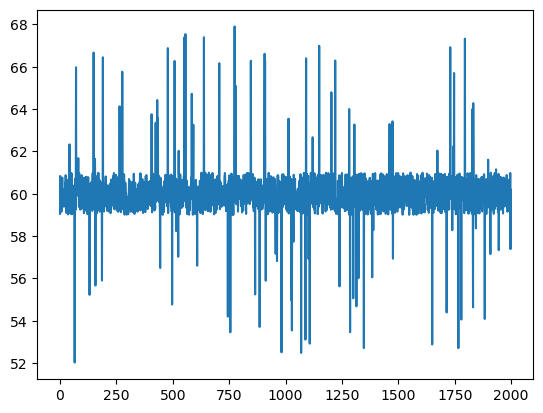

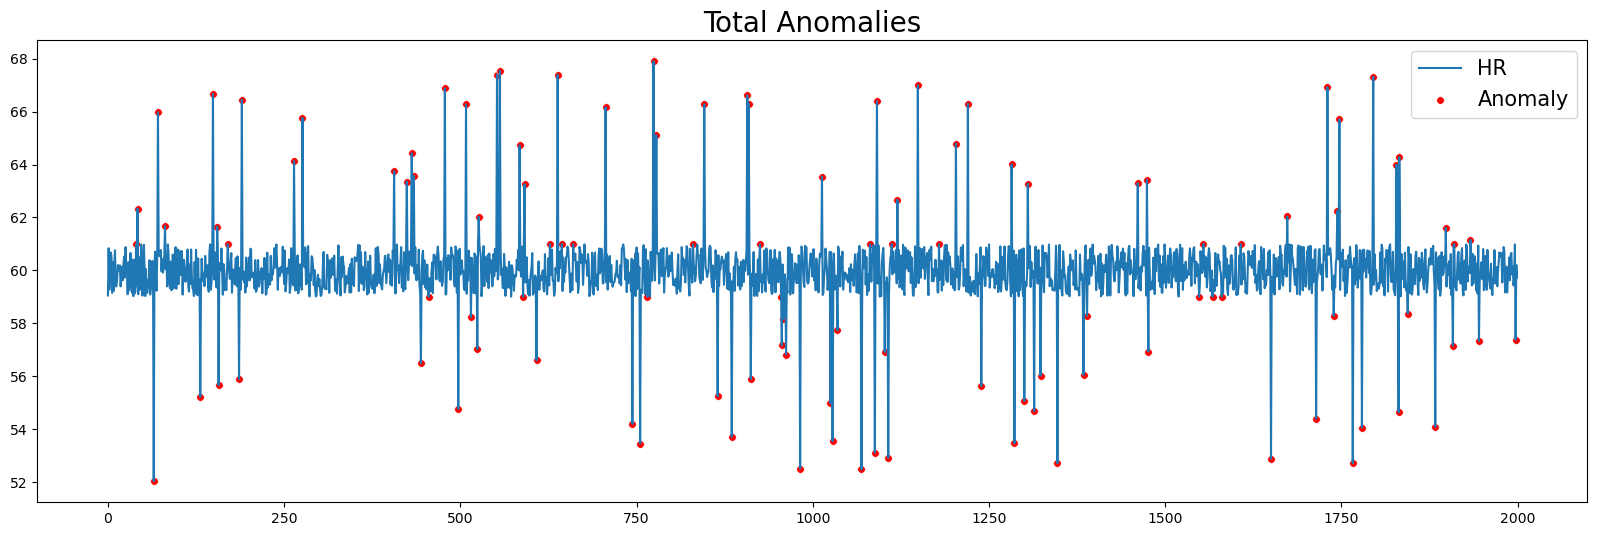

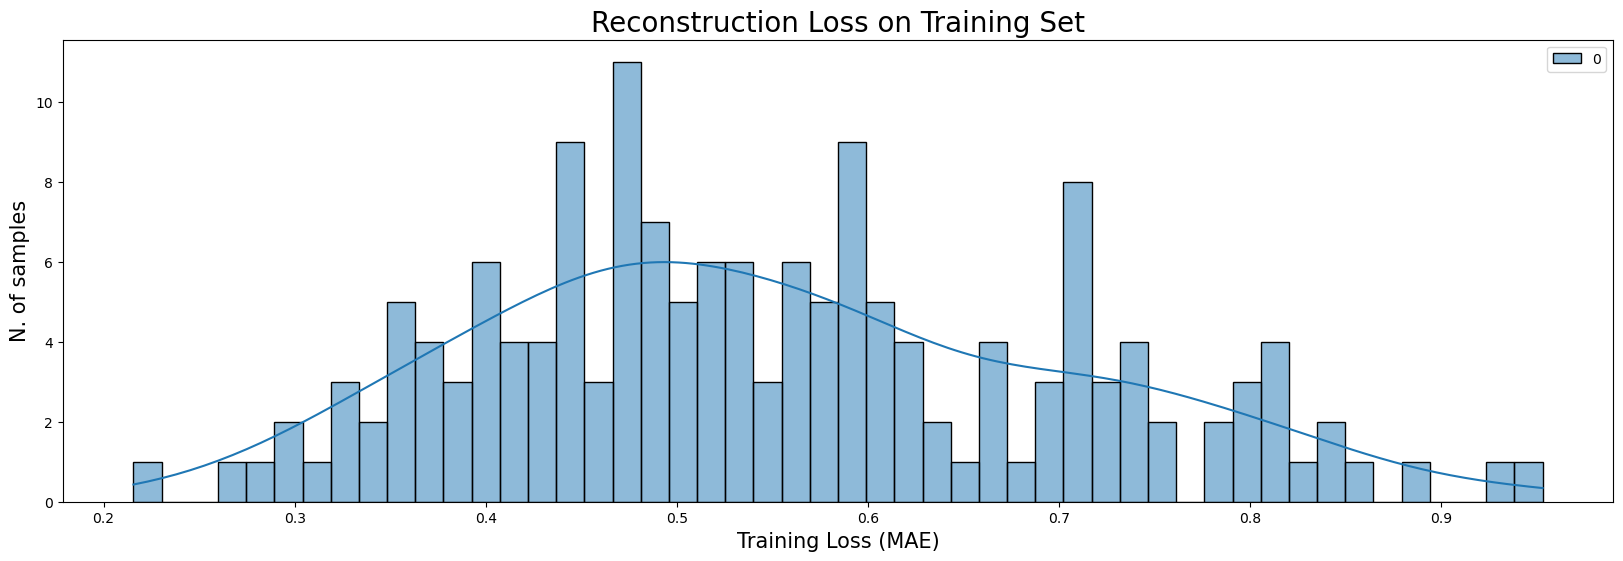

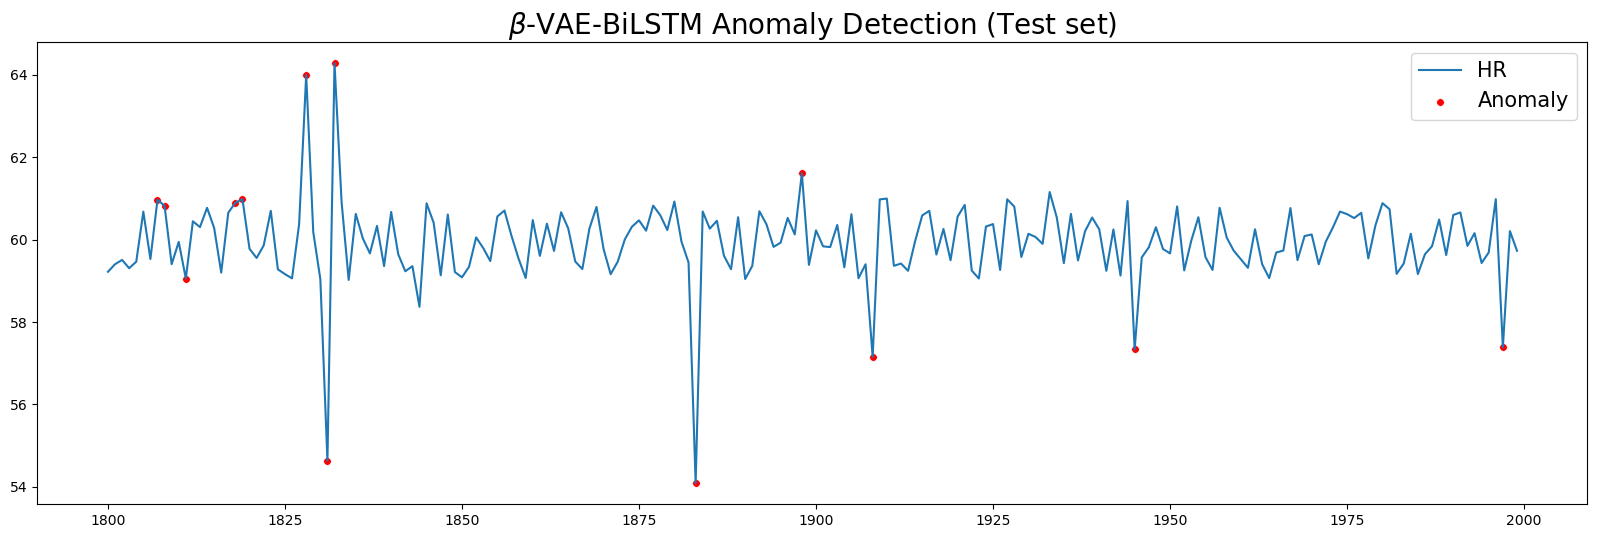

In [18]:
if __name__ == '__main__':
    
    # 설정 파일(config.yml) 로드
    with open("config.yml") as file:
            config = yaml.safe_load(file)

    # =========================
    # 1. 시계열 데이터 생성
    # =========================
    data = list(time_series_generator(median=config['median'], outlier_err=config['outlier_err'], 
                                      size=config['inliers_size'], outlier_size=config['outliers_size']))
    plt.plot(data)
    plt.savefig('./outcome/generated_time_series.png')

    # =========================
    # 2. 이상치 라벨링
    # =========================
    data_df = pd.DataFrame(data).rename(columns={0:"HR"})
    data_df, total_anomalies, time = data_labeling_algorithm(data_df, data, if_estimators=config['if_estimators'], 
                                                       if_random_state=config['if_random_state'], 
                                                       if_contamination=config['if_contamination'], kd_algo=config['kd_algo'], 
                                                       kd_kernel=config['kd_kernel'], kd_metric=config['kd_metric'], 
                                                       kd_score=config['kd_score'], svm_nu=config['svm_nu'], 
                                                       svm_kernel=config['svm_kernel'], svm_gamma=config['svm_gamma'],
                                                       sw_window_percentage=config['sw_window_percentage'], sw_std=config['sw_std'])

 
    plt.figure(figsize=(20,6))
    plt.plot(data_df.index, data_df[["HR"]], label="HR")
    sns.scatterplot(x=data_df[data_df["total_anomalies"] == True].index, 
                    y=data_df[data_df["total_anomalies"] == True][["HR"]].values.reshape(-1,), 
                    s=30, color="red", label="Anomaly")
    plt.title("Total Anomalies", size=20)
    plt.legend(fontsize=15)
    plt.savefig('./outcome/labeled_anomalies.png')


    # =========================
    # 3. 데이터 분할 및 전처리
    # =========================
    # 데이터 분할
    train, validation, test = data_split(data_df, 
                                         train_delimiter=config['train_delimiter'], 
                                         validation_delimiter=config['validation_delimiter'])
    # 학습 데이터의 이상치 제거
    anomalies = sorted(total_anomalies)
    cleaned_train = train_cleaning(train, anomalies)

    # 검증/테스트셋에서 이상치 인덱스 확인
    index_anomalies_validation, index_anomalies_test = anomalies_validation_test(cleaned_train, validation, test, time, anomalies)

    
    # 데이터프레임 변환 및 정규화
    train_df = pd.DataFrame(cleaned_train).rename(columns={0:"HR"})
    validation_df = pd.DataFrame(validation)
    test_df = pd.DataFrame(test)
    scaler = StandardScaler()
    train_df, validation_df, test_df = data_scaling(train_df,validation_df,test_df, scaler)

    # =========================
    # 4. 시퀀스 단위로 데이터 분할
    # =========================
    # 시퀀스 길이 기준으로 LSTM 입력 생성
    train_X = np.array_split(train_df.values.reshape(-1), int(len(train_df)/config['sequence_length']))
    train_X = np.array(train_X).reshape(np.array(train_X).shape[0], np.array(train_X).shape[1], 1)

    validation_X = np.array_split(validation_df.values.reshape(-1), int(len(validation_df)/config['sequence_length']))
    validation_X = np.array(validation_X).reshape(np.array(validation_X).shape[0], np.array(validation_X).shape[1], 1)

    test_X = np.array_split(test_df.values.reshape(-1), int(len(test_df)/config['sequence_length']))
    test_X = np.array(test_X).reshape(np.array(test_X).shape[0], np.array(test_X).shape[1], 1)

    # =========================
    # 5. β-VAE 모델 정의 및 학습
    # =========================
    n_features = config['n_features']
    input_dim = len(train_X[0])
    latent_space_dim = config['latent_space_dimension']
    optimizer = config['optimizer']

    encoder = vae_encoder(input_dim, n_features, latent_space_dim, n_units=config['vae_n_units'])
    decoder = vae_decoder(input_dim, n_features, latent_space_dim, n_units=config['vae_n_units'])
    vae = beta_vae(input_dim, n_features, encoder, decoder, beta=config['beta'])
    vae.compile(optimizer = optimizer)

    es = EarlyStopping(monitor = "val_loss", patience = config['es_patience'], mode = "min")
    print("Training Beta-VAE...")
    vae.fit(train_X, batch_size=config['batch_size'], validation_split=config['validation_split'], 
                     epochs=config['n_epochs'], shuffle=False, callbacks = [es])
    
    # 재구성 손실 시각화
    train_mae_loss = reconstruction_loss(vae, train_X)
    plt.figure(figsize=(20,6))
    plt.title("Reconstruction Loss on Training Set", size=20)
    plt.xlabel("Training Loss (MAE)", fontsize=15)
    plt.ylabel("N. of samples", fontsize=15)
    sns.histplot(train_mae_loss, bins=50, kde=True)
    plt.savefig('./outcome/train_reconstruction_loss.png')

    # =========================
    # 6. 임베딩 추출
    # =========================
    latents_train = encoder.predict(train_X)[0]
    latents_validation = encoder.predict(validation_X)[0]
    latents_test = encoder.predict(test_X)[0]

    flattened_latents_train = np.concatenate(latents_train).ravel()
    flattened_latents_validation = np.concatenate(latents_validation).ravel()
    flattened_latents_test = np.concatenate(latents_test).ravel()

    # =========================
    # 7. BiLSTM 학습
    # =========================
    n_embeddings_in = config['n_embeddings_in']
    n_steps_in = latent_space_dim * n_embeddings_in
    n_steps_out = latent_space_dim

    emb_train_X, emb_train_y = split_sequence(flattened_latents_train,n_steps_in,n_steps_out)
    emb_validation_X, emb_validation_y = split_sequence(flattened_latents_validation,n_steps_in,n_steps_out)
    emb_test_X, emb_test_y = split_sequence(flattened_latents_test,n_steps_in,n_steps_out)
    emb_train_X = emb_train_X.reshape(emb_train_X.shape[0], emb_train_X.shape[1], 1)
    emb_validation_X = emb_validation_X.reshape(emb_validation_X.shape[0], emb_validation_X.shape[1], 1)
    emb_test_X = emb_test_X.reshape(emb_test_X.shape[0], emb_test_X.shape[1], 1)

    # BiLSTM 모델 정의 및 컴파일
    bilstm_model = bilstm(emb_train_X, n_steps_out=n_steps_out, n_units=config['bilstm_n_units'], maximum_norm=config['max_norm'], 
                          dropout_rate=config['dropout_rate'])
    bilstm_model.compile(optimizer = optimizer, loss = MeanAbsoluteError(), metrics = [RootMeanSquaredError()])

    mc = ModelCheckpoint('vae_lstm_anomalydetection', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    print("Training BiLSTM backend...")
    history = bilstm_model.fit(emb_train_X, emb_train_y, validation_data=(emb_validation_X,emb_validation_y), 
                               batch_size=config['batch_size'], epochs=config['n_epochs'],verbose=1,callbacks=[es,mc])
    # 학습된 BiLSTM 모델 불러오기
    saved_model = load_model('vae_lstm_anomalydetection', custom_objects={'rmse':RootMeanSquaredError()})

    # =========================
    # 8. 임베딩 예측 및 복원
    # =========================
    for_index = pd.concat([cleaned_train,validation])
    index_train, index_validation, = predict_index(for_index, train_df, n_steps_in, n_steps_out)
    val_predict_result, val_real_value = mean_across_steps(saved_model, emb_validation_X, emb_validation_y, index_validation, n_steps_out)
    val_predicted_embeddings, val_true_embeddings = model_predictions(val_predict_result, val_real_value, emb_train_y, latent_space_dim, n_embeddings_in)

    flattened_rescaled_val_decoded_yhat, flattened_rescaled_val_X = decoder_predicted_embeddings(decoder, val_predicted_embeddings, 
                                                                                                   scaler, validation_X)
    vae_lstm_validation_squared_errors = (flattened_rescaled_val_decoded_yhat - flattened_rescaled_val_X) ** 2

    train_predict_result, train_real_value = mean_across_steps(saved_model, emb_train_X, emb_train_y, index_train, n_steps_out)
    train_predicted_embeddings, train_true_embeddings = model_predictions(train_predict_result, train_real_value, emb_train_y, latent_space_dim, n_embeddings_in)
    
    flattened_rescaled_train_decoded_yhat, flattened_rescaled_train_X = decoder_predicted_embeddings(decoder, train_predicted_embeddings, scaler, train_X)
    vae_lstm_train_squared_errors = (flattened_rescaled_train_decoded_yhat - flattened_rescaled_train_X) ** 2

    # =========================
    # 9. Threshold 최적화 및 테스트셋 평가
    # =========================
    selected_margin = margin_comparison_and_selection(vae_lstm_train_squared_errors, vae_lstm_validation_squared_errors,
                                                      validation_df, index_anomalies_validation, flattened_rescaled_val_X)


    index_test = list(range(len(cleaned_train + validation), len(cleaned_train + validation) + len(test)))
    test_predict_result, test_real_value = mean_across_steps(saved_model, emb_test_X, emb_test_y, index_test, n_steps_out)
    test_predicted_embeddings, test_true_embeddings = model_predictions(test_predict_result, test_real_value, 
                                                                        emb_validation_y, latent_space_dim, n_embeddings_in)

    flattened_rescaled_test_decoded_yhat, flattened_rescaled_test_X = decoder_predicted_embeddings(decoder, test_predicted_embeddings, scaler, test_X)
    vae_lstm_test_squared_errors = (flattened_rescaled_test_decoded_yhat - flattened_rescaled_test_X) ** 2

    threshold = find_threshold(vae_lstm_train_squared_errors, selected_margin)
    test_anomalies = find_anomalies(vae_lstm_test_squared_errors, threshold)

    # =========================
    # 10. 이상치 시각화 및 평가
    # =========================
    vae_lstm_test_df = pd.DataFrame(index=test_df.index)
    vae_lstm_test_df["HR"] = flattened_rescaled_test_X
    vae_lstm_test_df["anomalies_vae_lstm"] = test_anomalies
    anomalies_vae_lstm = vae_lstm_test_df[vae_lstm_test_df.anomalies_vae_lstm == True]
    
    plt.figure(figsize=(20,6))
    plt.plot(vae_lstm_test_df.index, vae_lstm_test_df[["HR"]], label="HR")
    sns.scatterplot(x=anomalies_vae_lstm.index, y=anomalies_vae_lstm[["HR"]].values.reshape(-1,), 
                    s=30, color="red", label="Anomaly")
    plt.title(r"$\beta$-VAE-BiLSTM Anomaly Detection (Test set)", size=20)
    plt.legend(fontsize=15)
    plt.savefig('./outcome/test_anomaly_detection.png')

    # =========================
    # 성능 평가 출력
    # =========================
    augmented_anomalies_vae_lstm = augmented_detection(anomalies_vae_lstm, index_anomalies_test)
    precision, recall, f1_score = metrics(index_anomalies_test, augmented_anomalies_vae_lstm)

    print("Performance on test set")
    print("Precision: ", round(precision,3))
    print("Recall: ", round(recall,3))
    print("F1-Score: ", round(f1_score,3))
